In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

### Step 3 - Climate Analysis and Exploration

You are now ready to use Python and SQLAlchemy to do basic climate analysis and data exploration on your new weather station tables. All of the following analysis should be completed using SQLAlchemy ORM queries, Pandas, and Matplotlib.

    * Create a Jupyter Notebook file called `climate_analysis.ipynb` and use it to complete your climate analysis &  data exporation.

    * Choose a start date and end date for your trip. Make sure that your vacation range is approximately 3-15 days   total.

    * Use SQLAlchemy `create_engine` to connect to your sqlite database.

    * Use SQLAlchemy `automap_base()` to reflect your tables into classes and save a reference to those classes called  `Station` and `Measurement`.

In [2]:
# Create the connection engine
engine = create_engine("sqlite:///hawaii.sqlite")
conn = engine.connect()

In [3]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

In [4]:
# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [5]:
# Reflect Database into ORM class
Base = automap_base()
Base.prepare(engine, reflect=True)
Measurements = Base.classes.measurement
Stations = Base.classes.station

### Precipitation Analysis

    * Design a query to retrieve the last 12 months of precipitation data.

    * Select only the `date` and `prcp` values.

    * Load the query results into a Pandas DataFrame and set the index to the date column.

    * Plot the results using the DataFrame `plot` method.

 <center><img src='images/precip.png' /></center>

    * Use Pandas to print the summary statistics for the precipitation data.

In [6]:
session = Session(engine)

In [7]:
# Design a query to retrieve the last 12 months of precipitation data.
# Select only the `date` and `prcp` values.
results = (session.query(Measurements.station,Measurements.date, Measurements.prcp).\
    filter(Measurements.date > '2016-12-31').\
    filter(Measurements.date < '2018-01-01').\
    order_by(Measurements.date.asc())).statement

In [8]:
# Load the query results into a Pandas DataFrame and set the index to the date column.
results_df =pd.read_sql_query(results, session.bind)
results_df.head()
results_df.set_index('date',inplace=True)
results_df = results_df.rename(columns={'prcp':'Precipitation'}, inplace=False)
results_df.head()

,station,Precipitation
date,,
2017-01-01,USC00519397,0.00
2017-01-01,USC00513117,0.29
2017-01-01,USC00514830,0.00
2017-01-01,USC00519281,0.03
2017-01-01,USC00516128,0.03


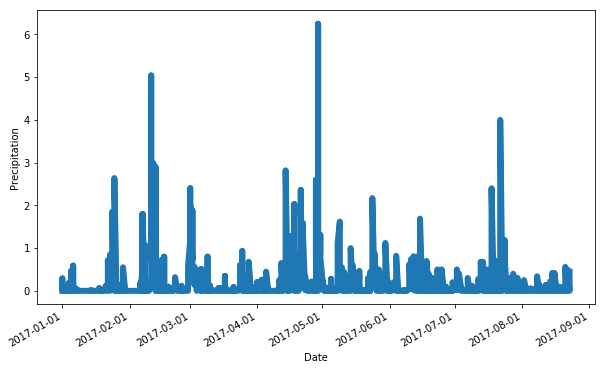

In [22]:
# Plot the results using the DataFrame `plot` method.
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
dates = results_df.index
x=[dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
y = results_df.Precipitation
plt.plot(x,y,linewidth=6)



plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().set_xlabel('Date')
plt.gca().set_ylabel('Precipitation')

plt.gcf().autofmt_xdate()
plt.gcf().savefig('images/precip.png')
plt.gcf().set_size_inches(10, 6)
plt.show()

In [23]:
# Use Pandas to print the summary statistics for the precipitation data.
results_df.describe()

,Precipitation
count,1267.000000
mean,0.165927
std,0.453913
min,0.000000
25%,0.000000
50%,0.000000
75%,0.105000
max,6.250000


### Station Analysis

    * Design a query to calculate the total number of stations.

    * Design a query to find the most active stations.

      * List the stations and observation counts in descending order

      * Which station has the highest number of observations?

    * Design a query to retrieve the last 12 months of temperature observation data (tobs).

      * Filter by the station with the highest number of observations.

      * Plot the results as a histogram with `bins=12`.

<center><img src='images/temp_hist.png' height="400px" /></center>

In [11]:
# Design a query to calculate the total number of stations.
total_stations = session.query(func.count(Stations.name)).all()
total_stations

[(9)]

In [12]:
# Design a query to find the most active stations.
# List the stations and observation counts in descending order
most_active =  "select station.station, station.name, count(measurement.tobs) as Count from  station join measurement on station.station = measurement.station group by station.station order by Count desc"
most_active_df = pd.read_sql(most_active,conn)
most_active_df.head()

,station,name,Count
0,USC00519281,WAIHEE,2772
1,USC00513117,KANEOHE,2696
2,USC00519397,WAIKIKI,2685
3,USC00519523,WAIMANALO EXPERIMENTAL FARM,2572
4,USC00516128,MANOA LYON ARBO,2484


In [13]:
# Which station has the highest number of observations?
print(f"The station with highest number of observation is {most_active_df['name'][0]}({most_active_df['station'][0]}) with {most_active_df['Count'][0]} observations") 

The station with highest number of observation is WAIHEE (USC00519281) with 2772 observations


In [14]:
# Design a query to retrieve the last 12 months of temperature observation data (tobs).
query = "select station.station, station.name, count(measurement.tobs) as temp_obs from  station join measurement on station.station = measurement.station where  measurement.date between '2017-01-01' and '2017-12-31' group by station.station order by temp_obs desc"
query_results = pd.read_sql(query,conn)
query_results.head()

,station,name,temp_obs
0,USC00519397,WAIKIKI,230
1,USC00519281,WAIHEE,221
2,USC00513117,KANEOHE,212
3,USC00516128,MANOA LYON ARBO,204
4,USC00519523,WAIMANALO EXPERIMENTAL FARM,190


In [15]:
# Filter by the station with the highest number of observations.
temp_obs_waikiki = "select station.station, station.name, measurement.date, measurement.tobs from  station join measurement on station.station = measurement.station where  measurement.date between '2017-01-01' and '2017-12-31' and station.name like'%WAIKIKI%' order by measurement.tobs asc"
temp_obs_waikiki_df = pd.read_sql(temp_obs_waikiki,conn)
temp_obs_waikiki_df = temp_obs_waikiki_df.rename(columns={'tobs':'Temp Observations'}, inplace=False)
temp_obs_waikiki_df.tail()

,station,name,date,Temp Observations
225,USC00519397,WAIKIKI,2017-08-23,81.0
226,USC00519397,WAIKIKI,2017-07-26,82.0
227,USC00519397,WAIKIKI,2017-08-22,82.0
228,USC00519397,WAIKIKI,2017-06-12,83.0
229,USC00519397,WAIKIKI,2017-05-23,87.0


<function matplotlib.pyplot.show>

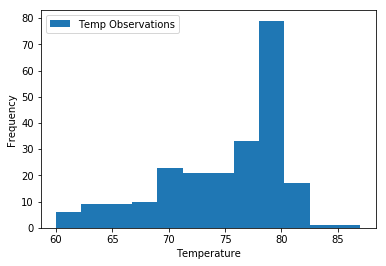

In [16]:
# Plot the results as a histogram with `bins=12`.
temp_obs_waikiki_df['Temp Observations'].plot(kind='hist',bins=12)
plt.xlabel('Temperature')
plt.legend()
plt.savefig('images/temp_hist.png')
plt.show

### Temperature Analysis

    * Write a function called `calc_temps` that will accept a start date and end date in the format `%Y-%m-%d` and return the minimum, average, and maximum temperatures for that range of dates.

    * Use the `calc_temps` function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")

    * Plot the min, avg, and max temperature from your previous query as a bar chart.

      * Use the average temperature as the bar height.

      * Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

<center><img src='images/temp_avg.png' height="400px"/></center>

In [17]:
# Write a function called `calc_temps` that will accept a start date and end date in the format `%Y-%m-%d` and 
# return the minimum, average, and maximum temperatures for that range of dates.
def calc_temps(start_date,end_date):
    query1 = "select max(tobs) as maximum , min(tobs) as minimum,  avg(tobs) as average from measurement where date between '{0}' and '{1}'".format(start_date, end_date)
    resultset = pd.read_sql(query1,conn)
    return resultset

In [18]:
# Use the `calc_temps` function to calculate the min, avg, and max temperatures for your trip 
# using the matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")
df=calc_temps("2012-09-12","2012-09-25")
df

,maximum,minimum,average
0,81.0,67.0,73.72043


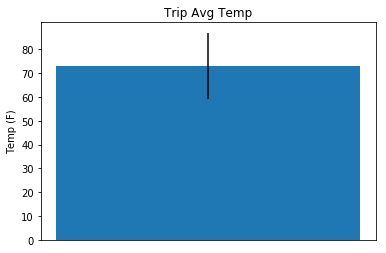

In [21]:
# Plot the min, avg, and max temperature from your previous query as a bar chart.
# Use the average temperature as the bar height.
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).
tmin = int(df['minimum'][0])
tmax = int(df['maximum'][0])
tavg = int(df['average'][0])

height = (tavg)
yerror = (tmin)  
plt.bar(np.arange(1), height, 0.15, yerr=tmax-tmin)

plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')
plt.xticks(np.arange(0))
plt.yticks(np.arange(0, 81, 10))
plt.savefig('images/temp_avg.png')
plt.show()